# ATSP Environment

We base our environment on our TSP implementation. The differences are:
1. `observation` is an NxN matrix of pairwise distance from all locations
2. We use the "tmat" class as done in [MatNet's implementation](https://github.com/yd-kwon/MatNet/tree/main/ATSP) - basically we sample so that we respect the triangle inequality:
$$
\begin{aligned}
d(c_i, c_j) + d(c_j, c_k) &\geq d(c_i, c_k) \forall i, j, k \in \{1, \dots, N\} \\
\end{aligned}
$$
3. To calculate the reward, we simply account for the distance taken from the matrix

In [1]:
%matplotlib inline

# Rich Traceback is a library that makes tracebacks more readable
# from rich.traceback import install
# install(show_locals=True)

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(2*"../")

from collections import defaultdict
from typing import Optional

import numpy as np
import torch
import tqdm
from tensordict.nn import TensorDictModule
from tensordict.tensordict import TensorDict, TensorDictBase
from torch import nn

from torchrl.data import BoundedTensorSpec, CompositeSpec, UnboundedContinuousTensorSpec, BinaryDiscreteTensorSpec, UnboundedDiscreteTensorSpec
from torchrl.envs import (
    CatTensors,
    EnvBase,
    Transform,
    TransformedEnv,
    UnsqueezeTransform,
)
from torchrl.envs.transforms.transforms import _apply_to_composite
from torchrl.envs.utils import check_env_specs, step_mdp


from rl4co.envs.utils import make_composite_from_td, batch_to_scalar, _set_seed

### Making the custom environment

Environment `_step`: this defines the state update of the TSP problem gived a TensorDict (`td` in the code) of the current state and the action to take:

In [3]:
def _step(td: TensorDict) -> TensorDict:
    current_node = td["action"]
    first_node = current_node if batch_to_scalar(td["i"]) == 0 else td["first_node"]

    # Set not visited to 0 (i.e., we visited the node)
    available = td["action_mask"].scatter(
        -1, current_node[..., None].expand_as(td["action_mask"]), 0
    )

    # We are done there are no unvisited locations
    done = (
        torch.count_nonzero(available.squeeze(), dim=-1) <= 0
    )  # td["params"]["num_loc"]

    # The reward is calculated outside via get_reward for efficiency, so we set it to -inf here
    reward = torch.ones_like(done) * float("-inf")

    # The output must be written in a ``"next"`` entry
    return TensorDict(
        {
            "next": {
                "observation": td["observation"],
                "first_node": first_node,
                "current_node": current_node,
                "i": td["i"] + 1,
                "action_mask": available,
                "reward": reward,
                "done": done,
            }
        },
        td.shape,
    )

### Environment Reset
This defines the `_reset` of the TSP. It returns a TensorDict of the initial state:

In [4]:
def _reset(
    self, td: Optional[TensorDict] = None, init_obs=None, batch_size=None
) -> TensorDict:
    # If no tensordict (or observations tensor) is passed, we generate a single set of hyperparameters
    # Otherwise, we assume that the input tensordict contains all the relevant parameters to get started.
    init_dm = td["observation"] if td is not None else init_obs # dm = distance matrix
    if batch_size is None:
        batch_size = self.batch_size if init_dm is None else init_dm.shape[:-2]
    device = init_dm.device if init_dm is not None else self.device
    self.device = device

    # We allow loading the initial observation from a dataset for faster loading
    if init_dm is None:
        # number generator is on CPU by default, set device after
        init_dm = self.generate_data(batch_size=batch_size).to(device)

    # Other variables
    current_node = torch.zeros((*batch_size, 1), dtype=torch.int64, device=device)
    available = torch.ones(
        (*batch_size, 1, self.num_loc), dtype=torch.bool, device=device
    )  # 1 means not visited, i.e. action is allowed
    i = torch.zeros((*batch_size, 1), dtype=torch.int64, device=device)

    return TensorDict(
        {
            "observation": init_dm,
            "first_node": current_node,
            "current_node": current_node,
            "i": i,
            "action_mask": available,
        },
        batch_size=batch_size,
    )

### Environment metadata 

This defines the input and output domains of the environment - similar to Gym's `spaces`:

In [5]:
def _make_spec(self):
    """Make the observation and action specs from the parameters"""
    self.observation_spec = CompositeSpec(
        observation=BoundedTensorSpec(
            minimum=self.min_dist,
            maximum=self.max_dist,
            shape=(self.num_loc, self.num_loc),
            dtype=torch.float32,
        ),
        first_node=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        current_node=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        i=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        action_mask=UnboundedDiscreteTensorSpec(
            shape=(1, self.num_loc),
            dtype=torch.bool,
        ),
        shape=(),
    )
    self.input_spec = self.observation_spec.clone()
    self.action_spec = BoundedTensorSpec(
        shape=(1,),
        dtype=torch.int64,
        minimum=0,
        maximum=self.num_loc,
    )
    self.reward_spec = UnboundedContinuousTensorSpec(shape=(1,))
    self.done_spec = UnboundedDiscreteTensorSpec(shape=(1,), dtype=torch.bool)

## Reward function

Sometimes, we want to make it simpler to get the reward outside. Normally, each step should give a reward; but in our case, reward is $-\infty$ unless finished The reason is that normally, we would have to collect all the previous locations and actions _inside_ the environment. But since the model already does that at the end, we can simply call the `get_reward` function to get the reward more efficiently.


In [6]:
def get_reward(td, actions) -> TensorDict:
    distance_matrix = td["observation"]
    assert (
        torch.arange(actions.size(1), out=actions.data.new())
        .view(1, -1)
        .expand_as(actions)
        == actions.data.sort(1)[0]
    ).all(), "Invalid tour"
    
    # Get indexes of tour. Actions: [batch_size, num_loc]
    nodes_src = actions
    nodes_tgt = torch.roll(actions, 1, dims=1)
    
    # Get distances of tour
    return distance_matrix[:, nodes_src, nodes_tgt]

### Data generation

In [7]:
int_min = 0
int_max = 1000*1000
node_cnt = 20
scaler = 1000*1000

batch_size = 30


problems = torch.randint(low=int_min, high=int_max, size=(batch_size, node_cnt, node_cnt))
# shape: (batch, node, node)
problems[:, torch.arange(node_cnt), torch.arange(node_cnt)] = 0

while True:
    print('aaaaa')

    old_problems = problems.clone()

    problems, _ = (problems[:, :, None, :] + problems[:, None, :, :].transpose(2,3)).min(dim=3)
    # shape: (batch, node, node)

    if (problems == old_problems).all():
        break

# Scale
scaled_problems = problems.float() / scaler
print(scaled_problems.mean(), scaled_problems.std())

aaaaa
aaaaa
aaaaa
aaaaa
aaaaa
tensor(0.1654) tensor(0.0957)


In [8]:
min_dist = 0
max_dist = 1
num_loc = 20

batch_size = [30]

dms = torch.rand((*batch_size, num_loc, num_loc),) * (max_dist - min_dist) + min_dist
dms[:, torch.arange(num_loc), torch.arange(num_loc)] = 0
while True:
    print('aaaaa')
    old_dms = dms.clone()
    dms, _ = (dms[:, :, None, :] + dms[:, None, :, :].transpose(2,3)).min(dim=3)
    if (dms == old_dms).all():
        break
dms / (max_dist - min_dist)
print(dms.mean(), dms.std())

aaaaa
aaaaa
aaaaa
aaaaa
tensor(0.1648) tensor(0.0991)


In [9]:
def generate_data(self, batch_size):
    # Generate distance matrices inspired by the reference MatNet (Kwon et al., 2021)
    # We satifsy the triangle inequality (TMAT class) in a batch 
    batch_size = [batch_size] if isinstance(batch_size, int) else batch_size
    dms = torch.rand((*batch_size, self.num_loc, self.num_loc), generator=self.rng) * (self.max_dist - self.min_dist) + self.min_dist 
    dms[..., torch.arange(self.num_loc), torch.arange(self.num_loc)] = 0
    while True:
        old_dms = dms.clone()
        dms, _ = (dms[..., :, None, :] + dms[..., None, :, :].transpose(-2,-1)).min(dim=-1)
        if (dms == old_dms).all():
            break
    return dms

### Environment creation

Here we use `EnvBase` to create the environment similarly to gym:

In [10]:
class ATSPEnv(EnvBase):
    batch_locked = False
    name = "atsp"

    def __init__(
        self,
        num_loc: int = 10,
        min_dist: float = 0,
        max_dist: float = 1,
        td_params: TensorDict = None,
        seed: int = None,
        device: str = "cpu",
    ):
        self.num_loc = num_loc
        self.min_dist = min_dist
        self.max_dist = max_dist

        super().__init__(device=device, batch_size=[])
        # self._make_spec(td_params)
        self._make_spec()
        if seed is None:
            seed = torch.empty((), dtype=torch.int64).random_().item()
        self.set_seed(seed)

    # Helpers: _make_step and gen_params
    # gen_params = gen_params # we don't use it for this case. See notebook 0
    _make_spec = _make_spec

    # Mandatory methods: _step, _reset and _set_seed
    _reset = _reset
    _step = staticmethod(_step)
    _set_seed = _set_seed

    # Get reward
    get_reward = staticmethod(get_reward)
    generate_data = generate_data

### Testing the environment

In [11]:
env = ATSPEnv(num_loc=10)
check_env_specs(env)

check_env_specs succeeded!


### Plotting

In [12]:
# Reset seed : check_env_specs(env) sets the seed to 0 for testing 
seed = torch.empty((), dtype=torch.int64).random_().item()
env.set_seed(seed)

2870139134

In [15]:
import networkx as nx


dm = env.generate_data(1)[0]
print(dm.shape)

torch.Size([10, 10])


1

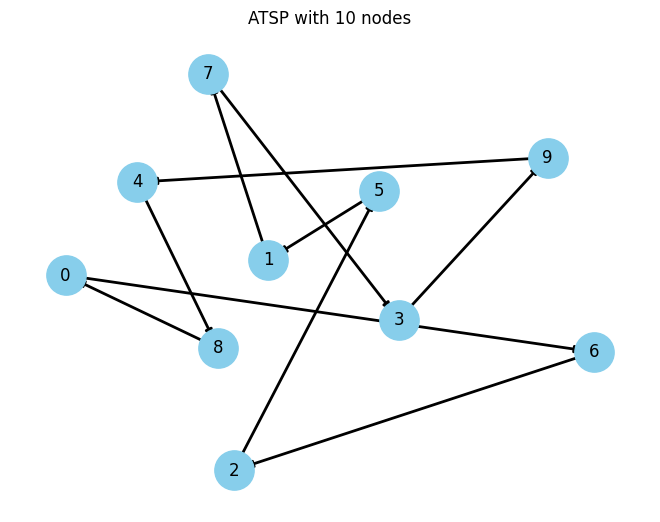

In [47]:
import matplotlib.pyplot as plt

def render(td):
    actions = torch.randperm(env.num_loc)

    src_nodes = actions
    tgt_nodes = torch.roll(actions, 1, dims=0)

    # Plot with networkx
    G = nx.DiGraph(dm.numpy())
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=800, edge_color='white')
    labels = nx.get_edge_attributes(G,'weight')

    # draw edges src_nodes -> tgt_nodes
    edgelist = [ (src_nodes[i].item(), tgt_nodes[i].item()) for i in range(env.num_loc) ]
    nx.draw_networkx_edges(G, pos, edgelist=edgelist, width=2, alpha=1, edge_color='black')

    # draw distance for edgelist

    plt.title(f'ATSP with {env.num_loc} nodes')


render(dm)
